## Instacart Market Basket Analysis

Instacart is a retail company that operates a grocery delivery and pick-up service. This service allows customers to order groceries from participating retailers with the shopping being done by a personal shopper. I am going to use Instacart user transactional data to predict which predict which previously purchased products will be in a user’s next order. 

### Table of Contents
1. Data Preprocessing
2. Exploratory Data Analysis
3. Market Basket Analysis
4. Conclusion


### Columns
- order_id: order unique identifier. this could include multiple product IDs, depending on the items purchased. 
- product_id: product unique identifier.
- add_to_cart_order: sequential number identifying number of items included in the same order.
- reordered: whether or not this item has been repurchased by the same customer.
- order_number: sequential number identifying order made by the same customer. each user's latest order is categorized as 'train', while all other previous orders are categorized as 'prior'.
- order_dow, order_hour_of_day: day and hour of purchase.
- days_since_prior_order: days since the previous order (not since the first order)
- department: large category of product
- aisle: detailed category of product 

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
ais = pd.read_csv('aisles.csv')
dep = pd.read_csv('departments.csv')
ord_prior = pd.read_csv('order_products__prior.csv') 
ord_train = pd.read_csv('order_products__train.csv')  
orders = pd.read_csv('orders.csv')
prod = pd.read_csv('products.csv')
sub = pd.read_csv('sample_submission.csv')

### Data Preprocessing

In [222]:
# checking for n/a values

print(orders.info(show_counts = True), ord_prior.info(show_counts = True), ord_train.info(show_counts = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                3421083 non-null  int64  
 1   user_id                 3421083 non-null  int64  
 2   eval_set                3421083 non-null  object 
 3   order_number            3421083 non-null  int64  
 4   order_dow               3421083 non-null  int64  
 5   order_hour_of_day       3421083 non-null  int64  
 6   days_since_prior_order  3214874 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int64
 1   product_id         32434489 non-null  int64
 2   add_to_cart_or

In [223]:
# check for duplicated values

print(ord_prior.duplicated().sum(), ord_train.duplicated().sum(), orders.duplicated().sum())

0 0 0


In [224]:
prod = prod.merge(dep, how = 'left', on= 'department_id')
prod = prod.merge(ais, how = 'left', on = 'aisle_id')
prod

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation
...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,alcohol,spirits
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,frozen,frozen vegan vegetarian
49685,49686,Artisan Baguette,112,3,bakery,bread
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,pets,cat food care


In [225]:
ord_prior = ord_prior.merge(prod, how = 'left', on = 'product_id')
ord_prior

# 각 고객의 가장 최근 주문건을 제외한 이전 모든 주문건들
# 원래는 reordered까지인데 product_name 부터는 내가 merge한 것. merge 필요없나 ??

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients
...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,household,dish detergents
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,crackers
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen,frozen breakfast
32434487,3421083,24852,9,1,Banana,24,4,produce,fresh fruits


In [226]:
ord_train = ord_train.merge(prod, how = 'left', on = 'product_id')
ord_train

# 각 유저별 가장 최근 주문

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,0,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,0,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood
...,...,...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,Natural Artesian Water,115,7,beverages,water seltzer sparkling water
1384613,3421063,35548,4,1,Twice Baked Potatoes,13,20,deli,prepared meals
1384614,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16,dairy eggs,soy lactosefree
1384615,3421070,16953,2,1,Creamy Peanut Butter,88,13,pantry,spreads


In [227]:
# orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(int)
# orders

# 유저별 주문/결제 내역
# eval_set은 prior, train, test로 이루어짐
# order_id는 결제번호. 여러 물품 주문했으면 다수의 product_id가 하나의 order_id에 속하나, 이건 주문 제품 관련 정보 안들어있음.

# 제품정보 합쳐야하나?

### Exploratory Data Analysis

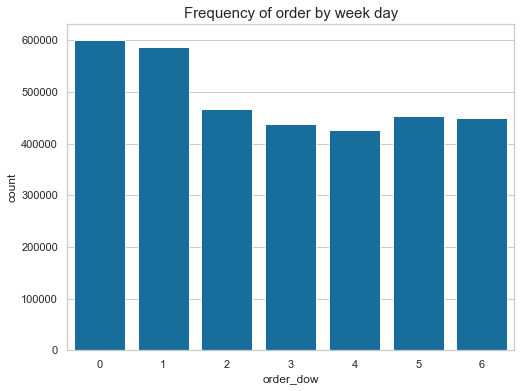

In [228]:
color = sns.color_palette()[0]
plt.figure(figsize=(8,6))
sns.countplot(x="order_dow", data=orders,color = color)
plt.title("Frequency of order by week day", fontsize=15);

월 (0), 화 (1) 주문이 많다. 주말에는 장도 안보고 쉬고 싶은 모양

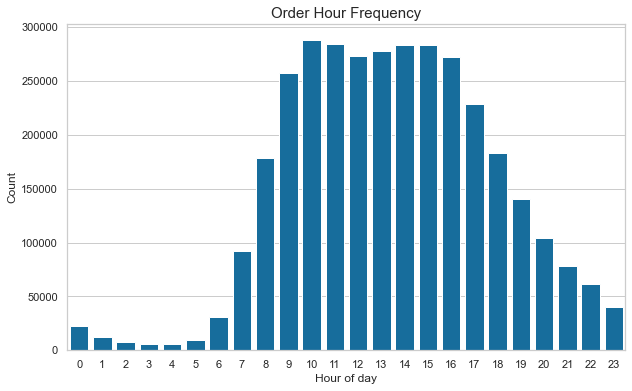

In [229]:
plt.figure(figsize=(10,6))
sns.countplot(x="order_hour_of_day", data=orders, color=color)
plt.ylabel('Count')
plt.xlabel('Hour of day')
plt.title("Order Hour Frequency", fontsize=15);

오전 9시에서 오후 5시까지 주문이 많다.

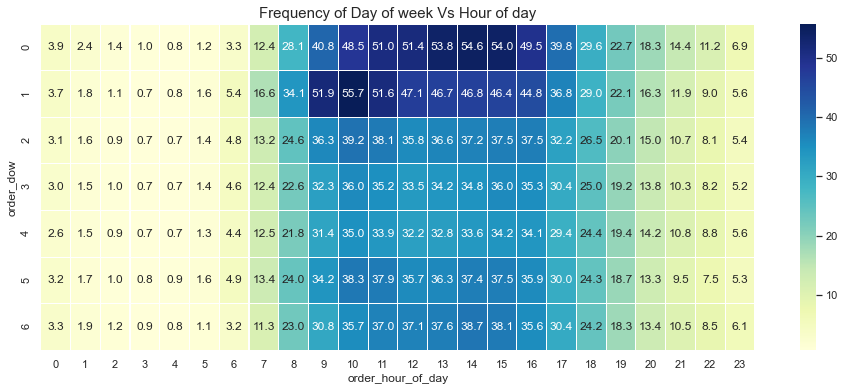

In [230]:
# 주문수 많은 시간대와 요일 조합

grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].agg(lambda x: len(x)/1000).reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(16,6))
sns.heatmap(grouped_df, cmap = 'YlGnBu', annot=True, fmt="1.1f", linewidths = .1)
plt.title("Frequency of Day of week Vs Hour of day", size = 15);

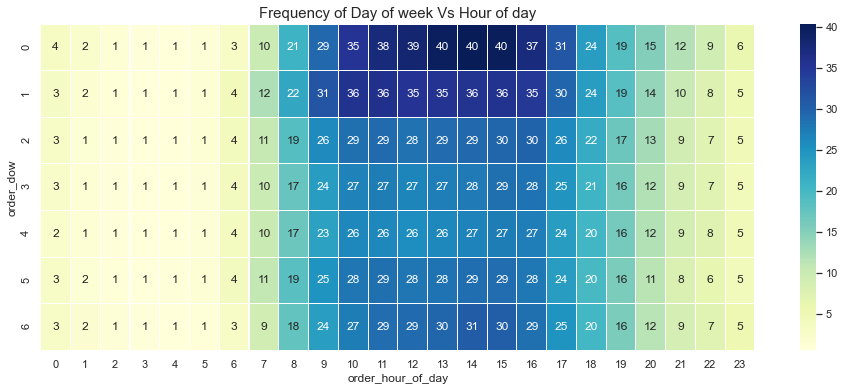

In [231]:
# 주문자수 많은 시간대와 요일 조합

grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["user_id"].agg(lambda x: x.nunique()/1000).reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'user_id')

plt.figure(figsize=(16,6))
sns.heatmap(grouped_df, cmap = 'YlGnBu', annot=True, fmt="1.0f", linewidths = .1)
plt.title("Frequency of Day of week Vs Hour of day", size = 15);

가장 주문이 많은 요일 및 시간대 조합: 월 점심시간 이후 (월요일 아침에 급한 업무 끝내놓고) & 화요일 출근해서 본격적인 업무 시작하기 전에

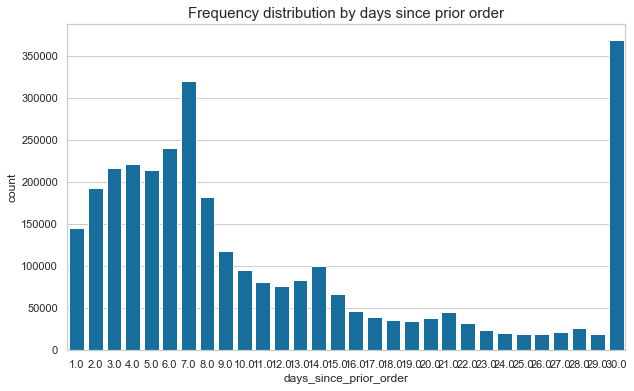

In [232]:
plt.figure(figsize=(10,6))
sns.countplot(x="days_since_prior_order", data=orders.query('days_since_prior_order > 0'), color=color)
plt.title("Frequency distribution by days since prior order", fontsize=15);

1주일이나 1달 간격으로 사는 사람이 많다.
1주일 이내는 신선식품을 주로 사는 사람들일거고, 1달은 비신선식품을 주로 사는 사람들일것.

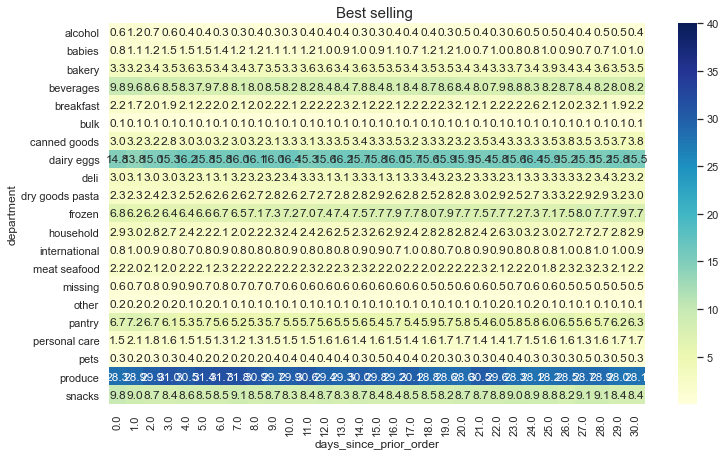

In [233]:
# 구매 간격과 제품 department 비교

ord_train_prod = ord_train.merge(orders, how = 'left', on = ['order_id'])
ord_train_pivot = ord_train_prod.groupby('days_since_prior_order')['department'].value_counts(normalize = True).mul(100).rename('percentage').reset_index()
grouped_df = ord_train_pivot.pivot(values = 'percentage', index = 'department', columns = 'days_since_prior_order')

plt.figure(figsize=(16,7))
sns.heatmap(grouped_df, cmap = 'YlGnBu', vmax = 40, annot=True, fmt="1.1f")
plt.title("Best selling ", size = 15);

- 확실히 1주일 언저리에 사는 사람들에게서 produce (fruits and vegetables), 유제품, 계란이 많은 것 입증. 
- 오래 안사는 사람에게는 frozen의 비중이 자주 사는 사람보다 살짝 높다.

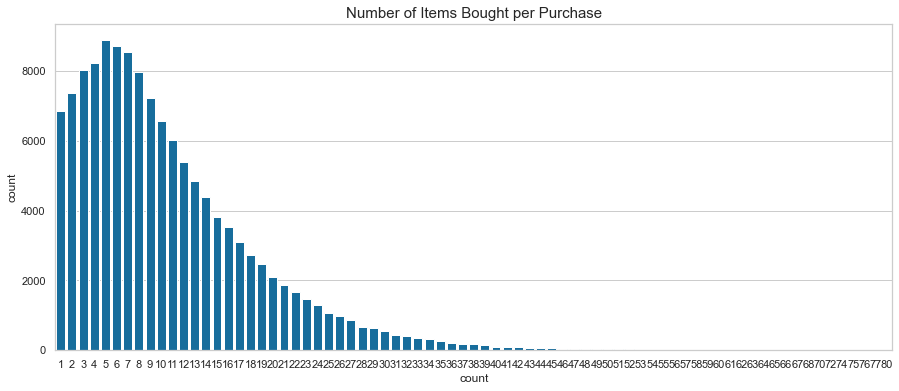

In [234]:
max_num = ord_train.groupby('order_id').add_to_cart_order.max().reset_index(name= 'count').head(70)
plt.figure(figsize=(15,6))
sns.countplot(x="count", data=max_num, color=color)
plt.title("Number of Items Bought per Purchase", fontsize=15);

- Customers purchase 5 items at a time, probably because of a delivery fee charged. 한개는 배송비떄문에 못사고, 여러개는 또 유통기한이 있기 때문에 한번에 많이 못삼. 그래서 보통 5개정도 삼. 
그렇다고 유통기한을 무시하고 한번에 더 많이 구매하게 하는건 소비자 패턴에 어긋나는거니까, 소액으로라도 더 자주 주문하는 것에 대한 부담을 낮추면 되잖아? 신선식품을 주로 주문하는 사람들에게 배송비를 낮춰주는건 어떨까? 그러면 여기서 사는게 더 편하니까 습관을 들이겠지.
- Combining the finding in the previous plot, people usually purchase 5-8 number of items at a time every 1 week or 1 month of interval.

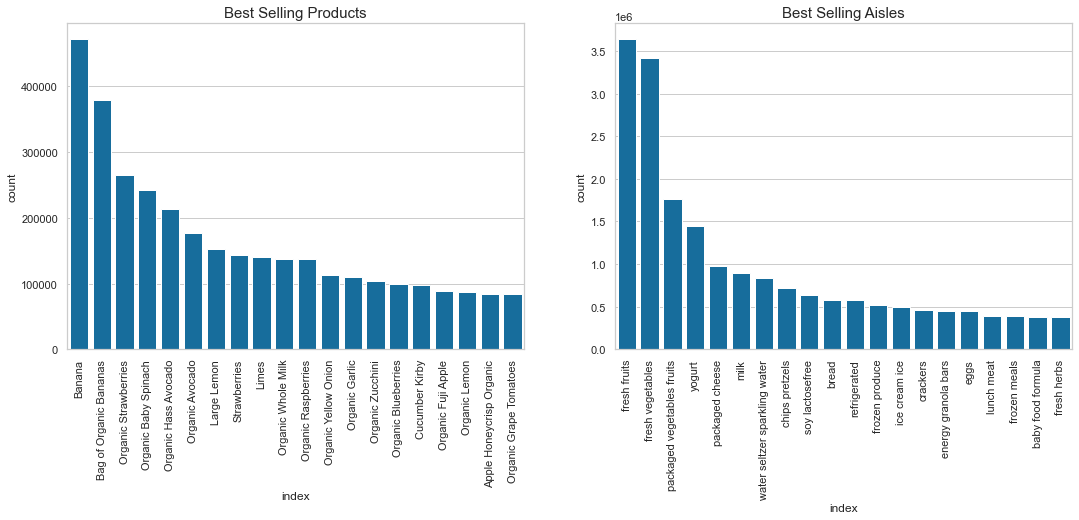

In [235]:
# 가장 구매가 많은 aisle과 상품명

ord_prior_merge = orders.merge(ord_prior, how = 'inner', on = 'order_id')
ord_prod = ord_prior_merge['product_name'].value_counts().reset_index(name = 'count').head(20)
ord_aisle = ord_prior_merge['aisle'].value_counts().reset_index(name = 'count').head(20)

fig,ax = plt.subplots(1,2, figsize = (18,6))
sns.barplot(x= 'index',y = 'count', data = ord_prod, color = color,ax = ax[0])
ax[0].set_xticklabels(labels = ord_prod['index'],rotation = 90)
ax[0].set_title("Best Selling Products", size = 15)

sns.barplot(x = ord_aisle['index'], y= ord_aisle['count'], ax = ax[1], color = color)
ax[1].set_xticklabels(labels = ord_aisle['index'],rotation =90)
ax[1].set_title("Best Selling Aisles", size = 15);

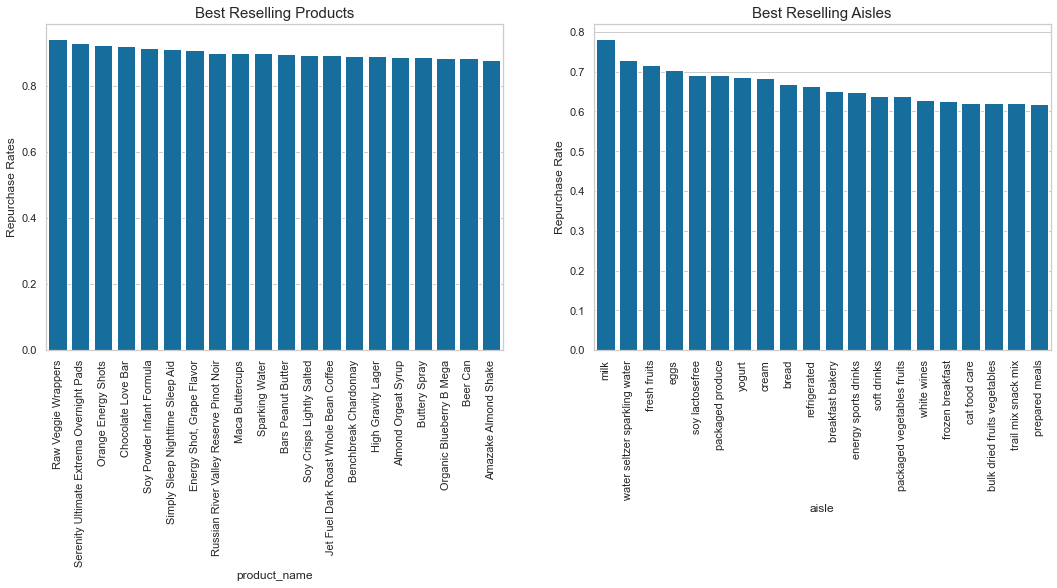

In [236]:
# 가장 재구매가 많은 aisle과 제품명

reord_prod = ord_prior_merge.groupby('product_name').reordered.mean().sort_values(ascending = False).head(20).reset_index()
reord_aisle = ord_prior_merge.groupby('aisle').reordered.mean().sort_values(ascending = False).head(20).reset_index()

fig,ax = plt.subplots(1,2, figsize = (18,6))
sns.barplot(x = reord_prod['product_name'], y= reord_prod['reordered'], ax = ax[0], color = color)
ax[0].set_xticklabels(labels = reord_prod['product_name'],rotation =90)
ax[0].set_title("Best Reselling Products", size = 15)
ax[0].set_ylabel("Repurchase Rates")

sns.barplot(data = reord_aisle, x = 'aisle', y= 'reordered', color = color,ax = ax[1])
ax[1].set_xticklabels(labels = reord_aisle['aisle'],rotation = 90)
ax[1].set_ylabel("Repurchase Rate")
ax[1].set_title("Best Reselling Aisles", size = 15);

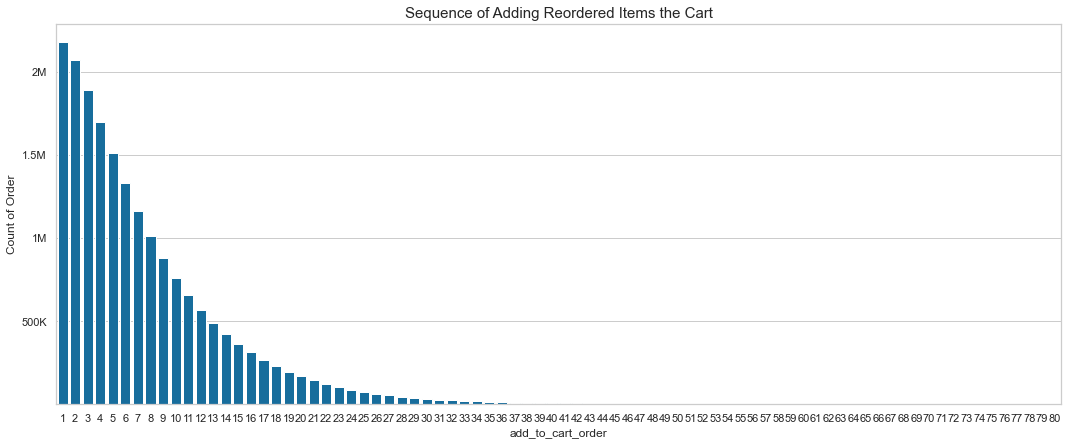

In [237]:
# 카트에 담기는 순서와 재구매. 한번 구매한적 있는 것이 다음번 카트에 담기는 순서.

ord_num = ord_prior_merge.query('reordered == 1').groupby('add_to_cart_order').count()['order_number'].reset_index().head(80)
plt.figure(figsize = (18,7))
sns.barplot(data = ord_num, x = 'add_to_cart_order', y= 'order_number', color = color)
plt.title("Sequence of Adding Reordered Items the Cart", size = 15)
plt.yticks([500000,1000000,1500000,2000000], labels = ['500K', '1M', '1.5M', '2M'])
plt.ylabel("Count of Order");

In [238]:
hour_product_ds = ord_prior_merge.groupby(['product_name','order_hour_of_day'], as_index=False).agg({'order_id':'count'})
hour_top_product = []
for (key, rows) in hour_product_ds.groupby('order_hour_of_day'):
    sub_ds = rows.sort_values('order_id', ascending=False)[:20]
    sub_ds['rank'] = list(range(1,20+1))
    hour_top_product.append(sub_ds)
hour_top_product

[                  product_name  order_hour_of_day  order_id  rank
 54717                   Banana                  0      2815     1
 51391   Bag of Organic Bananas                  0      2712     2
 494657    Organic Strawberries                  0      1839     3
 438675    Organic Baby Spinach                  0      1768     4
 465099    Organic Hass Avocado                  0      1398     5
 437978         Organic Avocado                  0      1176     6
 340617             Large Lemon                  0       981     7
 356473                   Limes                  0       938     8
 664290            Strawberries                  0       925     9
 504751      Organic Whole Milk                  0       922    10
 484339     Organic Raspberries                  0       919    11
 459723          Organic Garlic                  0       760    12
 441711     Organic Blueberries                  0       741    13
 507151        Organic Zucchini                  0       738  

In [239]:
hour_top_product_ds= pd.concat(hour_top_product)
hour_top_product_pivot_ds = hour_top_product_ds.pivot(index='order_hour_of_day', columns='product_name', values='rank')
pivot_ds = hour_top_product_pivot_ds.applymap(lambda x:hour_top_product_pivot_ds.max().max()-x+1)
pivot_ds.head()

product_name,Apple Honeycrisp Organic,Bag of Organic Bananas,Banana,Carrots,Cucumber Kirby,Half & Half,Honeycrisp Apple,Large Lemon,Limes,Organic Avocado,...,Organic Raspberries,Organic Red Onion,Organic Strawberries,Organic Whole Milk,Organic Yellow Onion,Organic Zucchini,Seedless Red Grapes,Sparkling Water Grapefruit,Spring Water,Strawberries
order_hour_of_day,,,,,,,,,,,,,,,,,,,,,
0,NaN,19.0,20.0,NaN,6.0,NaN,NaN,14.0,13.0,15.0,...,10.0,NaN,18.0,11.0,5.0,7.0,2.0,NaN,NaN,12.0
1,NaN,19.0,20.0,NaN,7.0,NaN,NaN,14.0,13.0,15.0,...,11.0,1.0,17.0,10.0,8.0,6.0,3.0,NaN,NaN,12.0
2,NaN,19.0,20.0,NaN,4.0,NaN,NaN,14.0,12.0,15.0,...,11.0,2.0,17.0,9.0,5.0,6.0,NaN,NaN,NaN,13.0
3,NaN,19.0,20.0,2.0,7.0,NaN,NaN,14.0,13.0,15.0,...,10.0,NaN,17.0,4.0,5.0,9.0,NaN,NaN,3.0,12.0
4,NaN,19.0,20.0,NaN,9.0,NaN,NaN,15.0,12.0,14.0,...,11.0,NaN,18.0,7.0,6.0,8.0,1.0,NaN,NaN,13.0


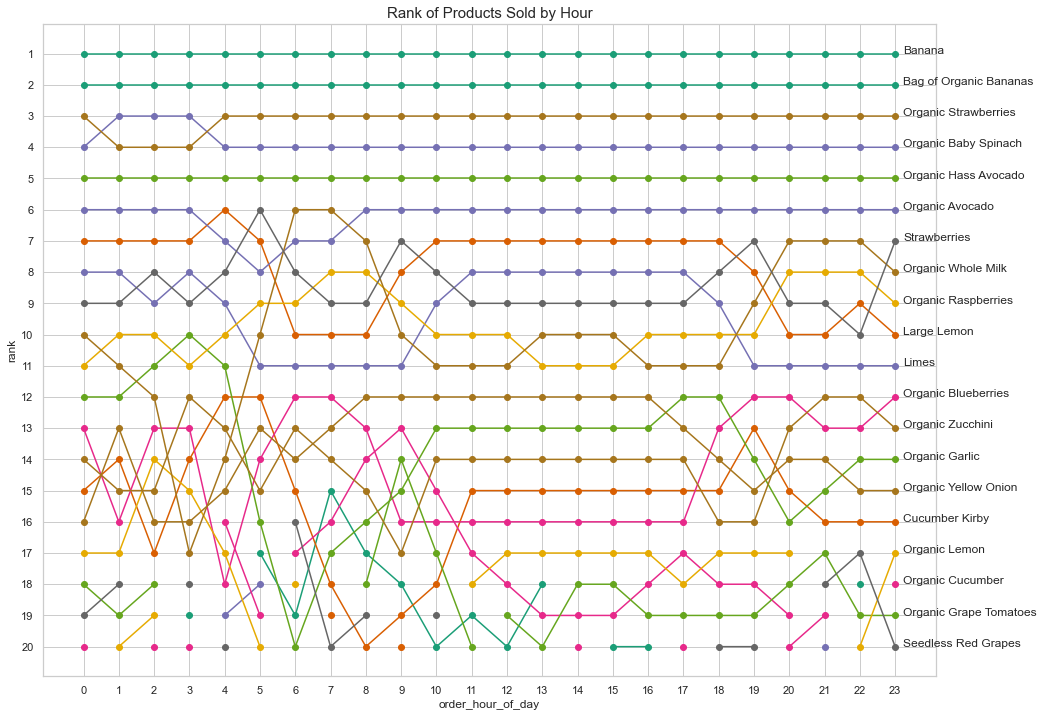

In [240]:
pivot_ds.plot(marker='o', figsize=(16,12), cmap='Dark2', xticks=pivot_ds.index, legend=None) 
plt.yticks(np.arange(20, 0, -1), np.arange(1, 20+1))
for name, rank in pivot_ds.loc[23].sort_values(ascending=False).dropna().iteritems():
    plt.text(23*1.01,rank,name)
plt.ylabel("rank")
plt.title("Rank of Products Sold by Hour", size = 15); 

In [241]:
dow_product_ds = ord_prior_merge.groupby(['product_name','order_dow'], as_index=False).agg({'order_id':'count'})
dow_product = []
for (key, rows) in dow_product_ds.groupby('order_dow'):
    sub_ds = rows.sort_values('order_id', ascending=False)[:20]
    sub_ds['rank'] = list(range(1,20+1))
    dow_product.append(sub_ds)
dow_product_ds= pd.concat(dow_product)
dow_top_product_pivot_ds = dow_product_ds.pivot(index='order_dow', columns='product_name', values='rank')
pivot_ds = dow_top_product_pivot_ds.applymap(lambda x:dow_top_product_pivot_ds.max().max()-x+1)

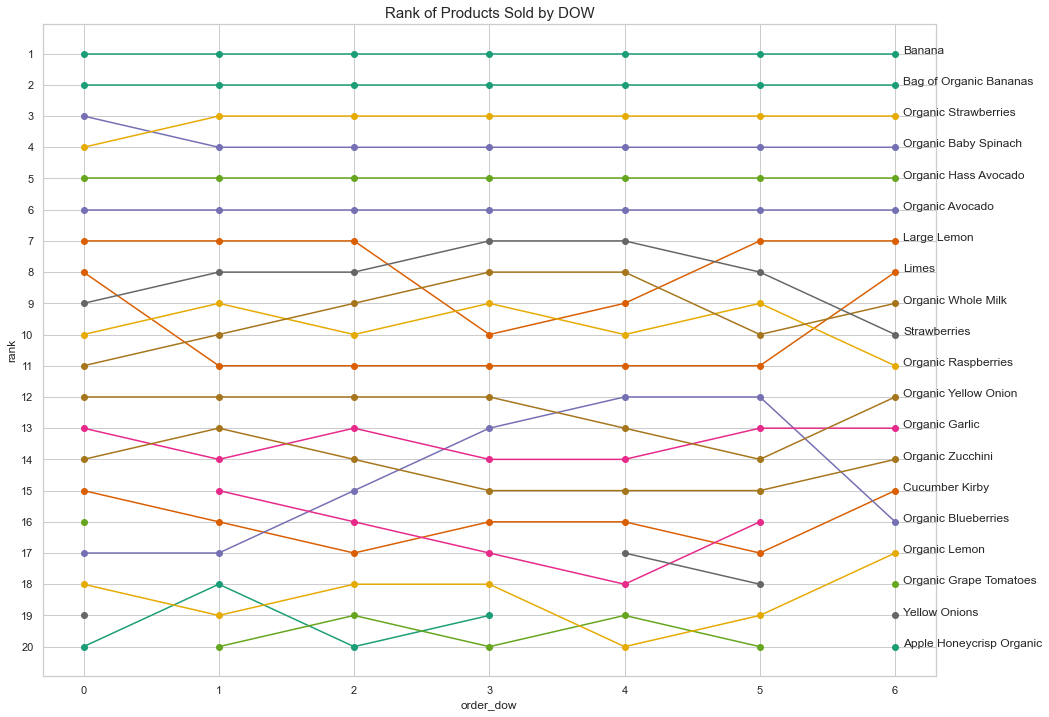

In [242]:
pivot_ds.plot(marker='o', figsize=(16,12), cmap='Dark2', xticks=pivot_ds.index, legend=None) 
plt.yticks(np.arange(20, 0, -1), np.arange(1, 20+1))

for name, rank in pivot_ds.loc[6].sort_values(ascending=False).dropna().iteritems():
    plt.text(6*1.01,rank,name)
plt.ylabel("rank")
plt.title("Rank of Products Sold by DOW", size = 15); 

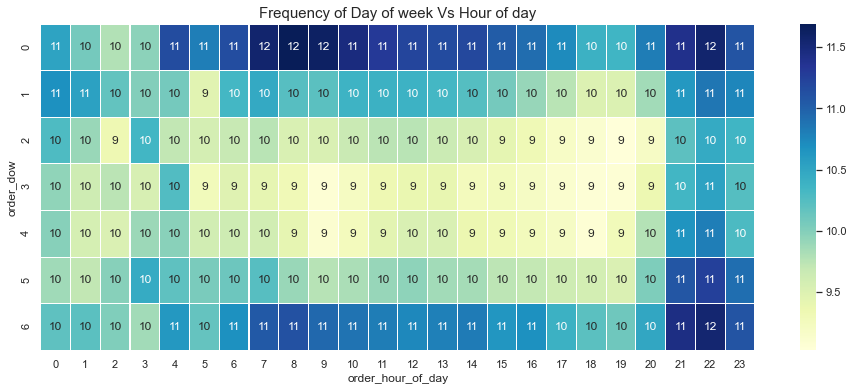

In [243]:
order_product_total = ord_prior.groupby('order_id')['product_id'].count().to_frame("product_cnt").reset_index()
orders = orders.merge(order_product_total, on = 'order_id', how = 'inner')
orders_pivot = orders.pivot_table(index ='order_dow' , columns = 'order_hour_of_day', values = 'product_cnt', aggfunc=lambda x: np.mean(x))

plt.figure(figsize=(18,6))
sns.heatmap(orders_pivot, cmap = 'YlGnBu', annot=True, fmt="1.1f", linewidths = .1)
plt.title("Frequency of Day of week Vs Hour of day", size = 15);

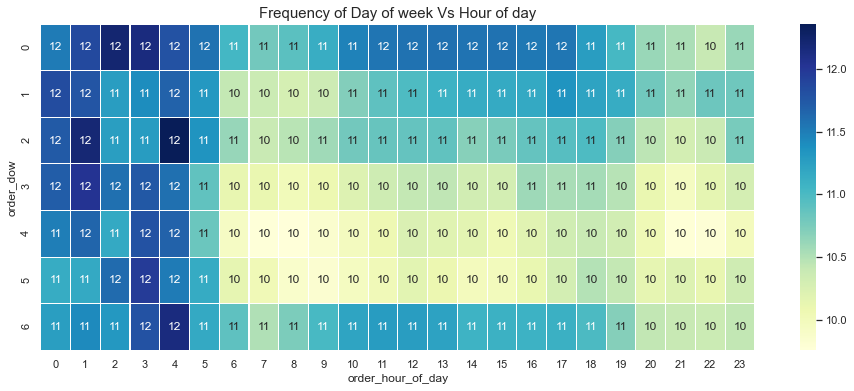

In [244]:
orders_pivot = orders.pivot_table(index ='order_dow' , columns = 'order_hour_of_day', values = 'days_since_prior_order', aggfunc=lambda x: np.mean(x))

plt.figure(figsize=(18,6))
sns.heatmap(orders_pivot, cmap = 'YlGnBu', annot=True, fmt="1.1f", linewidths = .1)
plt.title("Frequency of Day of week Vs Hour of day", size = 15);

Average Days Since Prior Order 10.71 Days


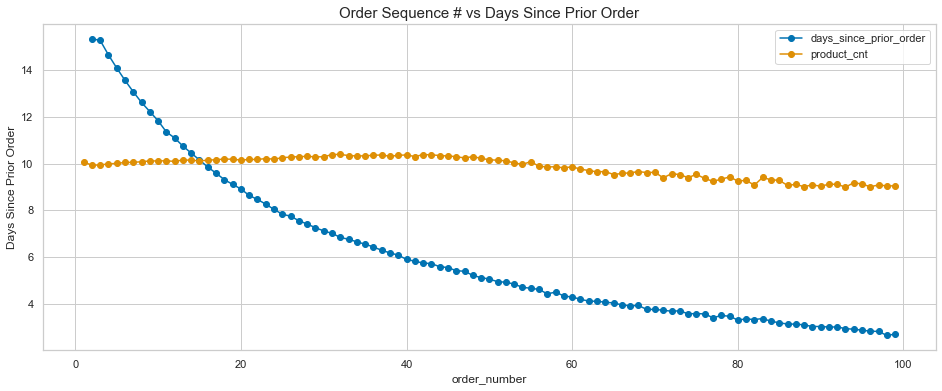

In [245]:
print("Average Days Since Prior Order {} Days".format(round(orders.days_since_prior_order.mean(),2)))

# 구매 횟수가 늘어날때마다 평균 쇼핑 간격 및 평균 구매 물건 갯수

orders_plot = orders.groupby('order_number').agg({'days_since_prior_order':np.mean, 'product_cnt':np.mean})
orders_plot.plot(figsize=(16,6), marker='o')
plt.ylabel('Days Since Prior Order')
plt.title("Order Sequence # vs Days Since Prior Order", size= 15);

In [246]:
# 재구매율

round(ord_prior_merge.query('days_since_prior_order > 0').groupby('reordered').count()['order_id'] *100 / ord_prior_merge.query('days_since_prior_order > 0').shape[0],2)

# 첫 구매 이후 구매한 물건들 중 62%가 이미 구매한 적 있는 물건들 -> 재구매하는 경향이 높다!

reordered
0    37.16
1    62.84
Name: order_id, dtype: float64

In [262]:
reordered_since_days_ds = ord_prior_merge.groupby(['days_since_prior_order','reordered']).agg({'product_id':'count'})
reordered_since_days_ds = reordered_since_days_ds.reset_index().pivot(index='days_since_prior_order', columns='reordered', values='product_id')
reordered_since_days_ds['reorder_rate'] = reordered_since_days_ds[1] /reordered_since_days_ds.sum(axis=1)

reordered_since_days_ds

reordered,0,1,reorder_rate
days_since_prior_order,,,
0.0,117219,331479,0.738757
1.0,359860,581256,0.617624
2.0,519388,945487,0.645439
3.0,622308,1255573,0.668612
4.0,670852,1409708,0.677562
5.0,693172,1433248,0.674019
6.0,813782,1706157,0.677063
7.0,1065830,2413674,0.693683
8.0,637581,1296234,0.670299


Text(0.5, 1.0, 'Reordered Product Rate (Avg 0.63)')

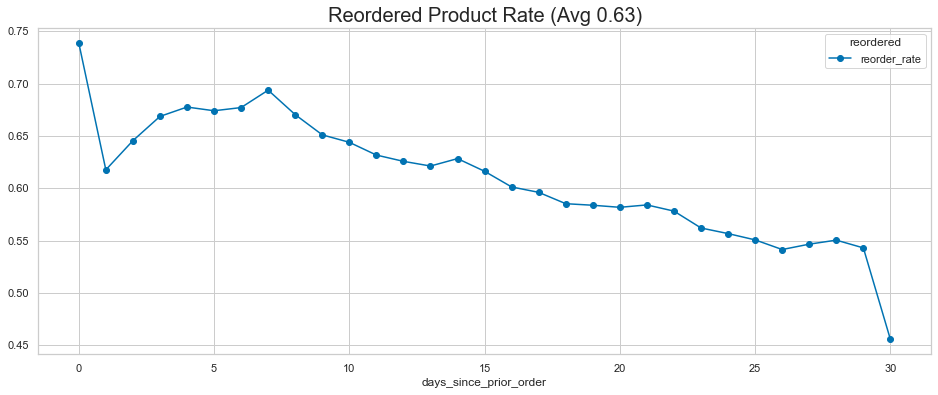

In [254]:
avg_reordered_rate = round(reordered_since_days_ds[1].sum() / reordered_since_days_ds[[0,1]].sum().sum(),2)

reordered_since_days_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize=20)

### Marktet Basket Analysis

In [27]:
# feature engineering

# purchase count per user
users = ord_prior_merge.groupby('user_id')['order_number'].max().to_frame('user_num_orders').reset_index()

# product purchased count for an order per user
total_product_per_order = ord_prior_merge.groupby(['user_id', 'order_id'])['product_id'].count().to_frame("total_prod_per_order").reset_index()

# average of product purchased per user 
avg_product_per_user = total_product_per_order.groupby(['user_id'])['total_prod_per_order'].mean().to_frame("user_avg_prod").reset_index()
del total_product_per_order 

users = users.merge(avg_product_per_user, on = 'user_id', how = 'left')
users

,user_id,user_num_orders,user_avg_prod
0,1,10,5.900000
1,2,14,13.928571
2,3,12,7.333333
3,4,5,3.600000
4,5,4,9.250000
...,...,...,...
206204,206205,3,10.666667
206205,206206,67,4.253731
206206,206207,16,13.937500
206207,206208,49,13.816327
